In [1]:
import os,sys,signal
import math

import pickle
import numpy as np                                       # fast vectors and matrices
import matplotlib.pyplot as plt                          # plotting

import musicnet

from time import time

from sklearn.metrics import average_precision_score

os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'   # see issue #152
os.environ['CUDA_VISIBLE_DEVICES']='2'

import torch
from torch.nn.functional import conv1d, mse_loss
import torch.nn.functional as F
import torch.nn as nn

if torch.cuda.is_available():
    device = "cuda:0"
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [2]:
# Network Parameters
epochs = 1000
train_size = 100000
test_size = 50000

lr = 0.0001
momentum = .95

pitch_shift = 0
jitter = 0.
num_workers = 10
sequence = 1

# lvl1 convolutions are shared between regions
m = 128
k = 512              # lvl1 nodes
n_fft = 4096              # lvl1 receptive field
window = 16384 # total number of audio samples?
stride = 512
batch_size = 100

regions = 1 + (window - n_fft)//stride

def worker_init(args):
    signal.signal(signal.SIGINT, signal.SIG_IGN) # ignore signals so parent can handle them
    np.random.seed(os.getpid() ^ int(time())) # approximately random seed for workers
kwargs = {'num_workers': num_workers, 'pin_memory': True, 'worker_init_fn': worker_init}

In [3]:
# function for returning scientific notation in a plot
def fmt(x, pos):
    a, b = '{:.0e}'.format(x).split('e')
    b = int(b)
    return fr'${a} \times 10^{{{b}}}$'

In [4]:
result_dict = {'loss_history_train': [],
               'avgp_history_train': [],
               'loss_history_test': [],
               'avgp_history_test': [],
               'parameters': {}}

result_dict['parameters']['train_size'] = train_size
result_dict['parameters']['test_size'] = test_size
result_dict['parameters']['lr'] = lr
result_dict['parameters']['pitch_shift'] = pitch_shift
result_dict['parameters']['jitter'] = jitter

# Preparing Dataset

In [5]:
start = time()
root = './data/'
train_set = musicnet.MusicNet(root=root, epoch_size=train_size,sequence=sequence
                              , train=True, download=True, refresh_cache=False, 
                              window=window, mmap=False, pitch_shift=pitch_shift, jitter=jitter)
test_set = musicnet.MusicNet(root=root, train=False, download=True,sequence=sequence
                             , refresh_cache=False, window=window, epoch_size=test_size, mmap=False)
print("Data loaded, time used = {:2.2f} seconds".format(time()-start))

train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size,**kwargs)
test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,**kwargs)

Data loaded, time used = 28.46 seconds


# Defining Models

In [6]:
Loss = torch.nn.MSELoss()
def L(yhatvar,y):
    return Loss(yhatvar,y) * 128/2

In [7]:
class Model(torch.nn.Module):
    def __init__(self, avg=.9998):
        super(Model, self).__init__()          
        # Creating Layers
        
        k_out = 128
        k2_out = 256
        
        self.conv1d = torch.nn.Conv1d(1,k,n_fft,stride)    
        
        self.CNN_freq = nn.Conv2d(1,k_out,
                                kernel_size=(128,1),stride=(2,1))
        self.CNN_time = nn.Conv2d(k_out,k2_out,
                                kernel_size=(1,25),stride=(1,1))        
        self.linear = torch.nn.Linear(49408, m, bias=False)


        
        
        wscale1 = 10e-3
        wscale2 = 10e-3
        # initialize filters for Fourier Transform
        torch.nn.init.normal_(self.conv1d.weight, std=wscale1)
        # initialize other network weights
        torch.nn.init.normal_(self.linear.weight, std=wscale2)
        
        self.avg = avg
        
    def forward(self,x):
        zx = torch.log(1 + torch.relu(self.conv1d(x[:,None,:]))) # shape = (batch, 512,25)
        z2 = torch.relu(self.CNN_freq(zx.unsqueeze(1))) # Make channel as 1 (N,C,H,W) shape = [10, 128, 193, 25]
        z3 = torch.relu(self.CNN_time(z2)) # shape = [10, 256, 193, 1]
        y = self.linear(torch.relu(torch.flatten(z3,1)))
        return y

In [8]:
model = Model()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = SWA(base_opt, swa_start=0, swa_freq=1, swa_lr=0.000001)

In [23]:
try:
    with train_set, test_set:
        print("epoch\ttrain loss\ttest loss\ttrain avg\ttest avg\ttime\tutime")
        for e in range(epochs):
            yground = torch.Tensor(batch_size*len(train_loader), m) # what not do this together with loss
            yhat = torch.Tensor(batch_size*len(train_loader), m)
            avgp, loss_e = 0.,0
            t = time()
            for i, (x,y) in enumerate(train_loader):
                print(f"training {i}/{len(train_loader)} batches", end = '\r')
                optimizer.zero_grad()

                # making x and y into pytorch dealable format
                x = x.to(device, non_blocking=True)
                y = y.to(device, non_blocking=True)
                yhatvar = model(x)
                loss = L(yhatvar,y)
                loss.backward()
                loss_e += loss.item() #getting the number

                yground[i*batch_size:(i+1)*batch_size] = y.data
                yhat[i*batch_size:(i+1)*batch_size] = yhatvar.data

                optimizer.step()
            avgp = average_precision_score(yground.cpu().flatten(),yhat.cpu().flatten())  

            result_dict['loss_history_train'].append(loss_e/len(train_loader))
            result_dict['avgp_history_train'].append(avgp)   
            t1 = time()
            avgp, loss_e = 0.,0.           
#             optimizer.swap_swa_sgd() # change to average weight

            # For testing
            yground = torch.Tensor(batch_size*len(test_loader), m) # what not do this together with loss
            yhat = torch.Tensor(batch_size*len(test_loader), m)

            for i, (x_test,y_test) in enumerate(test_loader):
                print(f"testing {i}/{len(test_loader)} batches", end = '\r')
                x_test = x_test.to(device)
                y_test = y_test.to(device)
                yhatvar = model(x_test)
                loss_e += L(yhatvar, y_test).item() #getting the number

                yground[i*batch_size:(i+1)*batch_size] = y_test.data
                yhat[i*batch_size:(i+1)*batch_size] = yhatvar.data
            avgp = average_precision_score(yground.cpu().flatten(),yhat.cpu().flatten())
            result_dict['loss_history_test'].append(loss_e/len(test_loader))
            result_dict['avgp_history_test'].append(avgp)
            print('{}\t{:2f}\t{:2f}\t{:2f}\t{:2f}\t{:2.1f}\t{:2.1f}'.\
                  format(e,
                         result_dict['loss_history_train'][-1],result_dict['loss_history_test'][-1],
                         result_dict['avgp_history_train'][-1],result_dict['avgp_history_test'][-1],
                         time()-t, time()-t1))

except KeyboardInterrupt:
    print('Graceful Exit')
else:
    print("Finsihed")

epoch	train loss	test loss	train avg	test avg	time	utime
0	1.140930	0.770296	0.352877	0.490901	223.8	21.9
1	0.952155	0.717688	0.521605	0.546214	213.9	21.7
2	0.909214	0.701864	0.559870	0.573399	221.8	22.5
3	0.883623	0.687978	0.580607	0.588238	214.1	21.9
4	0.868482	0.673410	0.596307	0.602429	223.0	38.0
5	0.857554	0.666748	0.603510	0.611743	223.9	23.5
6	0.845282	0.660624	0.612725	0.617886	216.8	23.8
7	0.840827	0.657452	0.619450	0.616161	224.3	24.6
8	0.833465	0.656416	0.624607	0.624531	231.2	22.5
9	0.828887	0.649861	0.629963	0.628194	223.5	21.4
10	0.818697	0.647715	0.637303	0.628925	239.8	28.8
11	0.816722	0.644385	0.639952	0.637328	224.8	23.1
12	0.814470	0.646542	0.642379	0.637275	209.9	21.1
13	0.810110	0.635533	0.648419	0.643472	212.8	21.0
14	0.806291	0.636604	0.649055	0.644775	221.3	22.6
15	0.801888	0.632691	0.654096	0.647480	209.7	20.6
16	0.800295	0.630981	0.654741	0.647363	221.1	24.4
17	0.798063	0.636033	0.658483	0.649116	218.7	21.8
18	0.793518	0.639387	0.659448	0.649926	215.0	21.9
19	

162	0.715316	0.598753	0.726855	0.689768	215.2	23.6
163	0.714981	0.598315	0.726672	0.685041	218.1	21.9
164	0.713474	0.602702	0.728064	0.688399	216.5	22.2
165	0.714594	0.597467	0.727919	0.690534	218.0	23.0
166	0.714679	0.600492	0.727044	0.688226	220.8	22.1
167	0.712133	0.601509	0.728418	0.688276	217.8	21.4
168	0.713723	0.595331	0.728376	0.691401	216.0	18.8
169	0.711773	0.601836	0.728580	0.687178	212.4	19.5
170	0.714610	0.590721	0.727769	0.694263	209.2	23.6
171	0.712818	0.601746	0.729487	0.690039	213.0	22.0
172	0.711571	0.595810	0.729629	0.694608	213.9	20.9
173	0.711870	0.595384	0.728986	0.690181	209.2	23.0
174	0.717414	0.594510	0.727231	0.690534	214.4	22.7
175	0.713040	0.595957	0.727940	0.690257	217.1	20.8
176	0.712992	0.595399	0.727962	0.695787	204.8	21.3
177	0.712530	0.598212	0.729078	0.688886	224.2	21.2
178	0.712594	0.599306	0.728708	0.687374	225.7	21.9
179	0.713875	0.594055	0.727777	0.693276	220.0	21.6
180	0.712357	0.598545	0.729814	0.691066	218.0	21.7
181	0.712391	0.592719	0.728136	

323	0.700081	0.587284	0.736782	0.700254	210.9	15.6
324	0.700019	0.582953	0.738411	0.699098	210.6	15.5
325	0.698855	0.589698	0.739040	0.696352	204.5	15.3
326	0.698095	0.588705	0.738767	0.695815	198.9	9.7
327	0.696834	0.589374	0.738603	0.696221	112.9	9.3
328	0.702390	0.586292	0.736015	0.699158	109.4	9.4
329	0.698894	0.588667	0.739805	0.693965	109.0	9.4
330	0.695628	0.589468	0.739152	0.696466	108.8	9.2
331	0.699427	0.587231	0.738789	0.700423	108.9	9.1
332	0.698174	0.583227	0.738448	0.700315	109.1	9.6
333	0.697378	0.593190	0.738141	0.692839	108.8	9.3
334	0.698220	0.590306	0.738392	0.693377	109.1	9.3
335	0.697866	0.587936	0.737445	0.696885	109.0	9.4
336	0.698283	0.589102	0.739094	0.697179	108.9	9.3
337	0.699575	0.587585	0.737934	0.697862	109.2	9.2
338	0.698457	0.585903	0.736883	0.695779	109.0	9.2
339	0.698520	0.587950	0.739693	0.697815	109.0	9.3
340	0.697220	0.590216	0.738625	0.698076	109.4	9.6
341	0.699023	0.589494	0.738180	0.694894	108.7	9.2
342	0.695760	0.586786	0.739541	0.696096	109.1	9

486	0.689262	0.581937	0.742817	0.700809	108.2	8.8
487	0.690469	0.582446	0.742224	0.701281	108.3	8.8
488	0.687822	0.582622	0.744232	0.696032	108.1	8.8
489	0.689180	0.588536	0.743266	0.701213	108.3	8.7
490	0.689180	0.583915	0.744040	0.699370	108.5	8.8
491	0.690710	0.583978	0.742490	0.698317	108.1	8.8
492	0.691428	0.585928	0.744304	0.700455	108.1	8.7
493	0.690172	0.581246	0.744980	0.702784	108.4	8.8
494	0.690764	0.581414	0.742443	0.702043	108.2	8.9
495	0.688897	0.580606	0.745236	0.700997	108.0	8.8
496	0.690231	0.580718	0.743235	0.702108	108.5	8.9
497	0.688558	0.584937	0.743732	0.696418	108.6	8.8
498	0.691615	0.587728	0.743421	0.700299	108.2	9.0
499	0.692373	0.584660	0.742741	0.699359	108.3	8.8
500	0.685988	0.580404	0.744600	0.699558	108.1	8.8
501	0.690336	0.579966	0.742256	0.699769	108.3	8.8
502	0.685239	0.578951	0.745224	0.707901	108.8	9.0
503	0.691814	0.579193	0.744752	0.702882	108.1	8.8
504	0.690619	0.582193	0.743537	0.698100	108.3	8.6
505	0.691054	0.586639	0.744507	0.696657	108.5	9.0


650	0.683761	0.577072	0.744542	0.703898	107.6	8.3
651	0.685692	0.584189	0.745724	0.697098	108.1	8.5
652	0.685030	0.584239	0.744951	0.701118	108.2	8.5
653	0.686572	0.584609	0.744814	0.694838	107.9	8.6
654	0.686504	0.575506	0.745355	0.702114	107.5	8.4
655	0.685812	0.577602	0.743692	0.703449	108.1	8.6
656	0.684223	0.578654	0.746131	0.700979	107.6	8.5
657	0.685367	0.581602	0.746473	0.699332	107.6	8.4
658	0.686167	0.575683	0.744155	0.705148	108.3	8.6
659	0.686645	0.577521	0.744352	0.701597	107.7	8.4
660	0.687756	0.583636	0.745228	0.699639	107.9	8.6
661	0.685847	0.579429	0.744292	0.701509	108.3	8.7
662	0.684782	0.581176	0.746316	0.699931	107.7	8.4
663	0.686165	0.578015	0.745755	0.704778	107.7	8.4
664	0.688210	0.578402	0.745234	0.702883	107.9	8.4
665	0.685156	0.583401	0.746336	0.703691	108.2	8.7
666	0.683534	0.579859	0.748259	0.701189	107.7	8.5
667	0.685653	0.589298	0.744946	0.697767	107.9	8.4
668	0.681326	0.583732	0.750496	0.701435	107.8	8.4
669	0.688077	0.583523	0.743361	0.699562	107.6	8.4


814	0.683618	0.576946	0.746984	0.703020	107.8	8.5
815	0.682584	0.585728	0.746607	0.701401	107.6	8.4
816	0.684322	0.581497	0.746014	0.701172	107.9	8.5
817	0.679658	0.582013	0.749353	0.700701	107.9	8.5
818	0.681154	0.585150	0.748112	0.702056	107.8	8.7
819	0.679022	0.576102	0.748381	0.704802	107.5	8.4
820	0.680326	0.572031	0.748224	0.708526	107.8	8.4
821	0.681953	0.577099	0.745737	0.700795	107.7	8.5
822	0.682757	0.579121	0.748726	0.698545	107.8	8.3
823	0.682035	0.580574	0.747910	0.697610	107.7	8.4
824	0.680497	0.585064	0.747360	0.701042	107.6	8.5
825	0.681535	0.579014	0.748589	0.706342	108.0	8.6
826	0.681354	0.580996	0.747730	0.701308	107.8	8.5
827	0.684024	0.573414	0.747464	0.709436	108.1	8.5
828	0.683749	0.577337	0.748338	0.704392	107.8	8.5
829	0.680457	0.586425	0.748052	0.701273	107.7	8.5
830	0.680250	0.577071	0.747071	0.701087	108.1	8.5
831	0.682509	0.577681	0.747338	0.707268	107.9	8.5
832	0.681723	0.576997	0.747209	0.703179	107.9	8.5
833	0.683816	0.579168	0.746623	0.700624	107.8	8.4


978	0.676688	0.583355	0.750733	0.696953	107.9	8.6
979	0.680593	0.573873	0.749081	0.703355	107.7	8.5
980	0.679844	0.579783	0.749697	0.703226	107.5	8.4
981	0.677525	0.580530	0.750361	0.702731	108.1	8.6
982	0.675839	0.574256	0.750436	0.707651	107.9	8.6
983	0.678536	0.576738	0.749963	0.704769	107.6	8.3
984	0.677468	0.574204	0.750186	0.704468	107.9	8.6
985	0.678295	0.575600	0.748323	0.704742	108.0	8.5
986	0.678858	0.576243	0.748487	0.699277	107.8	8.5
987	0.678760	0.574337	0.749758	0.703121	108.0	8.7
988	0.679002	0.574466	0.749169	0.705572	107.6	8.3
989	0.676629	0.570576	0.749104	0.707114	107.6	8.5
990	0.680138	0.576883	0.750043	0.707207	107.9	8.6
991	0.672168	0.573295	0.754800	0.704727	107.7	8.4
992	0.678269	0.584112	0.750586	0.702630	107.6	8.6
993	0.677366	0.575547	0.751365	0.702067	107.7	8.4
994	0.679710	0.578349	0.748859	0.699128	107.7	8.4
995	0.679790	0.575889	0.749463	0.703337	107.9	8.4
996	0.679448	0.580393	0.747892	0.702863	108.0	8.5
997	0.677803	0.578273	0.748898	0.706159	107.6	8.4


(0.3, 0.8)

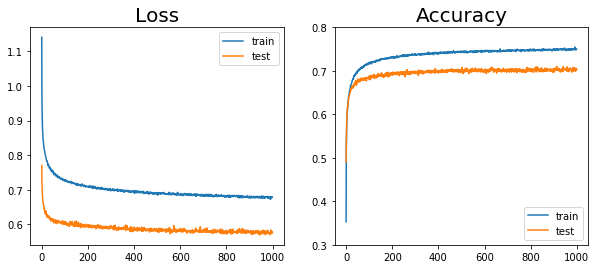

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))

ax[0].plot(result_dict['loss_history_train'])
ax[0].plot(result_dict['loss_history_test'])
ax[0].legend(['train', 'test'])
ax[0].set_title('Loss', size=20)

ax[1].plot(result_dict['avgp_history_train'])
ax[1].plot(result_dict['avgp_history_test'])
ax[1].legend(['train', 'test'])
ax[1].set_title('Accuracy', size=20)
ax[1].set_ylim(0.3,0.80)

# Mir_Eval stats

In [18]:
print('AvgP\tP\tR\tAcc\tETot\tESub\tEmiss\tEfa')
Accavg = 0
Etotavg = 0
for songid in test_set.rec_ids:
    Y_pred, Y_true = musicnet.get_piano_roll(songid, test_set, model, device,
                                             window=window, m=m, stride=-1)
    Yhatpred = Y_pred > 0.4
    _,_,_,Acc,Etot = musicnet.get_mir_accuracy(Y_pred, Y_true, m=m)
    Accavg += Acc
    Etotavg += Etot

AvgP	P	R	Acc	ETot	ESub	Emiss	Efa
76.83	73.66	71.96	0.57	0.41	0.13	0.15	0.13
79.26	73.43	75.31	0.59	0.43	0.09	0.15	0.18
47.17	58.11	38.54	0.30	0.75	0.14	0.47	0.13
65.07	59.42	71.53	0.48	0.68	0.09	0.19	0.40
78.21	72.12	81.38	0.62	0.38	0.12	0.06	0.19
72.64	70.52	63.77	0.50	0.49	0.14	0.22	0.12
67.29	69.99	57.74	0.46	0.52	0.15	0.28	0.10
69.09	69.84	60.86	0.48	0.53	0.13	0.26	0.13
75.40	73.96	66.14	0.54	0.48	0.09	0.25	0.15
71.34	69.09	70.47	0.54	0.48	0.13	0.17	0.19


In [25]:
print('Average Accuracy: \t{:2.2f}\nAverage Error: \t\t{:2.2f}'
      .format(Accavg/len(test_set.rec_ids)*100, Etotavg/len(test_set.rec_ids)*100))

Average Accuracy: 	0.00
Average Error: 		0.00


# Saving weights and results

In [26]:
torch.save(model.state_dict(), './weights/channel_convolution')
with open('./result_dict/channel_convolution', 'wb') as f:
    pickle.dump(result_dict, f)